# Import modules

In [ ]:
%pip install -r requirements.txt

In [11]:
from utils.dataset import make_datapath_list, CrackDataset, CrackTransform
from utils.loss_function import DiceBCELoss
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np 
import torch.utils.data as data
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader

/Users/kikuta/Desktop/crack-segmentation-tutorial/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Visualize dataset

In [2]:
datapath = make_datapath_list(nfold=5)
train_paths, val_paths = datapath.get_train_val_lists(fold_index=0)
test_paths = datapath.get_test_lists()

In [3]:
print(train_paths)
print(val_paths)

(['data/Train/images/c1_0_6.jpg', 'data/Train/images/c1_5_0.jpg', 'data/Train/images/c1_1_2.jpg', 'data/Train/images/c1_4_2.jpg', 'data/Train/images/c1_1_1.jpg', 'data/Train/images/c1_1_7.jpg', 'data/Train/images/c1_3_0.jpg', 'data/Train/images/c1_2_8.jpg', 'data/Train/images/c1_0_8.jpg', 'data/Train/images/c1_4_8.jpg', 'data/Train/images/c1_2_3.jpg', 'data/Train/images/c1_4_7.jpg', 'data/Train/images/c1_5_5.jpg', 'data/Train/images/c1_3_4.jpg', 'data/Train/images/c1_4_0.jpg', 'data/Train/images/c1_5_1.jpg', 'data/Train/images/c1_1_5.jpg', 'data/Train/images/c1_1_6.jpg', 'data/Train/images/c1_2_1.jpg', 'data/Train/images/c1_5_6.jpg', 'data/Train/images/c1_4_5.jpg', 'data/Train/images/c1_0_5.jpg', 'data/Train/images/c1_0_7.jpg', 'data/Train/images/c1_3_5.jpg', 'data/Train/images/c1_5_3.jpg', 'data/Train/images/c1_2_5.jpg', 'data/Train/images/c1_1_8.jpg', 'data/Train/images/c1_5_7.jpg', 'data/Train/images/c1_4_6.jpg', 'data/Train/images/c1_1_4.jpg', 'data/Train/images/c1_4_4.jpg', 'data/

In [4]:
train_dataset = CrackDataset(train_paths[0], train_paths[1],transform=CrackTransform(crop_size=256))
val_dataset = CrackDataset(val_paths[0], val_paths[1],transform=CrackTransform(crop_size=256))

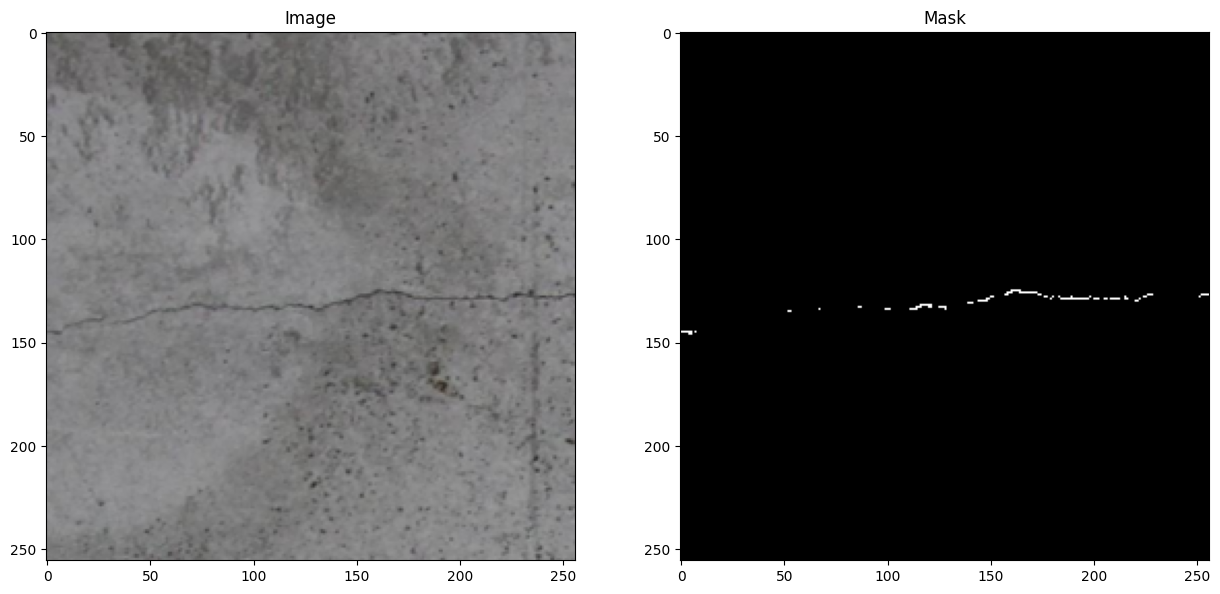

In [9]:
# データの可視化
i = 2
img, anno = train_dataset.__getitem__(i)
img = img.clone().numpy()
img = img.transpose((1,2,0))

anno = anno.clone().numpy()
anno = np.asarray(anno, np.float64)
anno = anno.transpose((1,2,0))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(anno, cmap='gray')
plt.title('Mask')
plt.show()

# Setup model

In [13]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
# segmentation_models_pytorchを利用
model = smp.DeepLabV3Plus(
    encoder_name='resnet18',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/kikuta/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.3MB/s]


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# Training (Cross Validation)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, device):
    model.to(device)
    earlystopping = EarlyStopping(patience=10)
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            for images, labels in dataloaders[phase]:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f}')

        print()

    print('Training complete')

In [ ]:
# Cross-validation
nfold = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 100

datapath = make_datapath_list(nfold)

for fold_index in range(nfold):
    print(f'Starting fold {fold_index + 1}/{nfold}')
    train_paths, val_paths = datapath.get_train_val_lists(fold_index=fold_index)

    train_dataset = CrackDataset(train_paths[0], train_paths[1], transform=CrackTransform(crop_size=256))
    val_dataset = CrackDataset(val_paths[0], val_paths[1], transform=CrackTransform(crop_size=256))

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    dataloaders = {
        'train': train_loader,
        'val': val_loader
    }

    # Train the model
    train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

In [ ]:
# early stopping counterとベストモデルの保存
# validation scoreの表示はやりたい

# Test